# [E5] Spectrogram classification

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
from os.path import isdir, join
import random
import copy

tf.__version__

'2.2.0'

In [2]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [3]:
test_wav = speech_data["wav_vals"][0]  
test_wav.shape

(8000,)

# Wave to spectrogram
STFT를 이용해서 wave 형태의 데이터를 spectrogram으로 만들어준다.

In [4]:
def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

spec = wav2spec(test_wav)
spec.shape

(130, 126)

In [5]:
spec.shape[0]

130

# spectrogram 으로 변환한 데이터를 plot

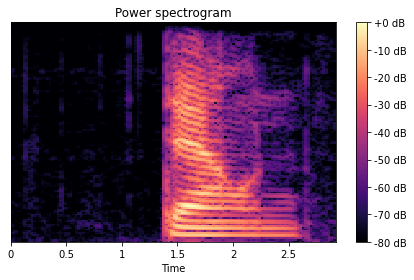

In [6]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram') # 2차원으로 보면 특징을 더 찾을 수 있음 소리를 2차원의 스펙트럼으로 표현
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# 전체 데이터셋의 wave데이터 spectrogram

In [7]:
temp = []
for v in speech_data["wav_vals"]:
    wav = v
    stft = wav2spec(wav)
    temp.append(stft)
data_wav = np.array(temp)

In [8]:
data_wav.shape

(50620, 130, 126)

### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.

In [9]:
train_wav, test_wav, train_label, test_label = train_test_split(data_wav, speech_data["label_vals"], 
                                                                test_size=0.1, 
                                                                random_state = 1993, 
                                                                shuffle=True)

train_wav = train_wav.reshape(-1, 130, 126, 1)
test_wav = test_wav.reshape(-1, 130, 126, 1)

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)



(45558, 130, 126, 1)
(5062, 130, 126, 1)
(45558, 1)
(5062, 1)


In [10]:
del data_wav
del speech_data

### Target_list 설정

In [11]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [12]:
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

In [13]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (45558, 130, 126, 1)
Train_Label Demension : (45558,)
Test_Wav Demension : (5062, 130, 126, 1)
Test_Label Demension : (5062,)
Number Of Labels : 12


### Hyper-parameter setting

In [14]:
batch_size = 64
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

## tf.data.dataset Setting

In [15]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [16]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## Model 구현

In [17]:
inputs = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(inputs)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(inputs, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [19]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [20]:

history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
711/711 [==============================] - ETA: 0s - loss: 0.7880 - accuracy: 0.7434
Epoch 00001: val_loss improved from inf to 0.29465, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
711/711 [==============================] - 177s 249ms/step - loss: 0.7880 - accuracy: 0.7434 - val_loss: 0.2947 - val_accuracy: 0.9039
Epoch 2/10
711/711 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9297
Epoch 00002: val_loss improved from 0.29465 to 0.19218, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
711/711 [==============================] - 175s 246ms/step - loss: 0.2170 - accuracy: 0.9297 - val_loss: 0.1922 - val_accuracy: 0.9367
Epoch 3/10
711/711 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9561
Epoch 00003: val_loss improved from 0.19218 to 0.12554, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
711/711 [==============================] - 176s 247ms/step - loss

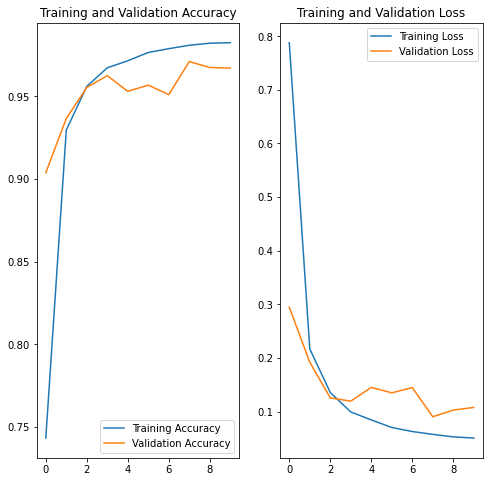

In [21]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


80/80 [==============================] - 30s 375ms/step - loss: 0.0905 - accuracy: 0.9710
loss value: 0.091
accuracy value: 97.0960%


In [23]:
# Test 
import IPython.display as ipd
import random

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

#ipd.Audio(batch_xs.reshape(16380,), rate=8000)

label :  right


In [24]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: right(Correct!)
✅


In [25]:
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.
evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.

SyntaxError: invalid syntax (<ipython-input-25-edb5d2d0372d>, line 1)